# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.optimizers import Adam,RMSprop
import datetime as dt
from dateutil.relativedelta import relativedelta
from yahoo_fin.stock_info import get_data,tickers_dow as dow,tickers_nasdaq as nasdaq,tickers_sp500 as sp500,get_premarket_price,get_postmarket_price
from yahoo_fin.options import get_calls,get_puts,get_expiration_dates

# Calculating Bollinger Bands

In [2]:
# Step 1: Calculate SMA (20-period)
def get_SMA(closing_prices, days):
    return closing_prices.rolling(days).mean()
# Step 2: Calculate std. deviation (14-period)
def get_std_dev(closing_prices, days):
    return closing_prices.rolling(days).std()
# Step 3: Create Bollinger Bands (1.5 std dev)
def get_BB(closing_prices, SMA_days, std_dev_days, rate):
    sma = get_SMA(closing_prices, SMA_days)
    std_dev = get_std_dev(closing_prices, std_dev_days)
    upper_bollinger = sma + std_dev*rate
    lower_bollinger = sma - std_dev*rate
    return upper_bollinger,lower_bollinger

# Calculating Keltner Channels

In [3]:
# Step 1: Calculate EMA (20-period)
def get_EMA(closing_prices, days):
    multiplier = 2 / (days + 1)
    ema = [closing_prices[0]]
    for price,EMA_yesterday in zip(closing_prices[1:],ema):
        ema.append(price * multiplier + EMA_yesterday * (1 - multiplier))
    return ema
# Step 2: Calculate ATR (20-period)
def get_ATR(high_prices,low_prices,closing_prices,days):
    high_low = high_prices-low_prices
    high_close = np.abs(high_prices-closing_prices.shift())
    low_close = np.abs(low_prices-closing_prices.shift())
    ranges = pd.concat([high_low,high_close,low_close],axis=1)
    trueRange = np.max(ranges,axis=1)
    atr = trueRange.rolling(days).sum()/days
    return atr
# Step 3: Calculate Keltner Channel
def get_KC(ema,shift,atr):
    upper_kc = ema + shift*atr
    lower_kc = ema - shift*atr
    return upper_kc,lower_kc

# Calculate Momentum

In [4]:
def get_momentum(closing_prices,days):
    momentum = []
    for day in range(days):
        momentum.insert(day,None)
    for current_price,previous_price in zip(closing_prices[days:],closing_prices):
        momentum.append(current_price - previous_price)
    return momentum

# Gather data

In [5]:
def gather_data(data):
    if not isinstance(data,pd.core.frame.DataFrame):
        df = pd.read_csv(data)
    else:
        df = data
    closing_prices = df['close']
    high_prices = df['high']
    low_prices = df['low']
    df['SMA'] = get_SMA(closing_prices,20)
    df['EMA'] = get_EMA(closing_prices,20)
    df['ATR'] = get_ATR(high_prices,low_prices,closing_prices,14)
    df['upper_KC'],df['lower_KC'] = get_KC(df['EMA'],1.5,df['ATR'])
    df['bollinger_up'],df['bollinger_down'] = get_BB(closing_prices,20,14,1.5)
    df['MA'] = get_SMA(closing_prices,14)
    df['momentum'] = get_momentum(closing_prices,14)
    return df

# Screener Algorithm

In [6]:
def screener(company):
    calls = ''
    puts = ''
    #fails = ''
    one_day_streak = ''
    two_days_streak = ''
    three_days_streak = ''
    four_days_streak = ''
    days_to_check = [-1,-2,-3,-4,-5]
    current_status = ''
    for day in days_to_check:
        today = company.iloc[day]
        ticker = today['ticker']
        today_price = today['close']
        today_upper_kc = today['upper_KC']
        today_lower_kc = today['lower_KC']
        today_upper_bb = today['bollinger_up']
        today_lower_bb = today['bollinger_down']
        today_ma = today['MA']
        today_momentum = today['momentum']
        if(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price > today_ma and today_momentum > 0 and current_status!='put'):
            calls = ticker
            current_status = 'call'
        elif(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price < today_ma and today_momentum < 0 and current_status!='call'):
            puts = ticker
            current_status = 'put'
        else:
            if day ==-5:
                calls = ''
                puts = ''
                four_days_streak = ticker + ' - ' + current_status
            elif day ==-4:
                calls = ''
                puts = ''
                three_days_streak = ticker + ' - ' + current_status
            elif day ==-3:
                calls = ''
                puts = ''
                two_days_streak = ticker + ' - ' + current_status
            elif day ==-2:
                calls = ''
                puts = ''
                one_day_streak = ticker + ' - ' + current_status
            break
    return calls,puts,one_day_streak,two_days_streak,three_days_streak,four_days_streak

# Screener

In [7]:
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))

calls = []
puts = []
fails = []
ones = []
twos = []
threes = []
fours = []

# Check an index
def check_index(function):
    index = function()
    index_hist = {}
    for ticker in index:
        data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
        company = gather_data(data)
        company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
        if company_calls!='':
            calls.append(company_calls)
        if company_puts!='':
            puts.append(company_puts)
        if company_ones!='':
            ones.append(company_ones)
        if company_twos!='':
            twos.append(company_twos)
        if company_threes!='':
            threes.append(company_threes)
        if company_fours!='':
            fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours


# Check individual stock
def check_stock(ticker):
    data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
    company = gather_data(data)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

# Check custom stock
def check_custom_stock(csv):
    company = gather_data(csv)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

In [8]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_index(sp500)
#stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_stock('AEP')
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

Calls (22): ['AJG', 'ANET', 'CMI', 'DE', 'DRI', 'GPC', 'IFF', 'INCY', 'IRM', 'KIM', 'KMI', 'MET', 'MMC', 'MPC', 'PFE', 'PRU', 'PSX', 'PWR', 'SRE', 'TXT', 'ULTA', 'VLO']
Puts (1): ['LYV']
4-days Streak (11): ['AMP - call', 'CF - put', 'CTVA - put', 'DLTR - call', 'EVRG - put', 'GILD - call', 'KR - call', 'LUV - call', 'MOS - put', 'TGT - put', 'VZ - call']
3-days Streak (20): ['AAL - put', 'AIG - call', 'ALK - call', 'ARE - call', 'BXP - put', 'CSGP - put', 'DXCM - put', 'ENPH - call', 'F - call', 'FMC - call', 'GLW - call', 'GWW - call', 'NCLH - put', 'OXY - put', 'PAYC - put', 'REGN - put', 'RMD - call', 'SPG - call', 'TRV - call', 'WM - call']
2-days Streak (36): ['ABC - call', 'ACGL - call', 'AEP - call', 'AME - call', 'CLX - call', 'CTLT - put', 'DG - call', 'DTE - call', 'DVN - put', 'ETR - call', 'FANG - put', 'FE - call', 'GEN - call', 'GM - call', 'HWM - call', 'INTU - put', 'JNJ - call', 'LDOS - call', 'MAA - call', 'MDLZ - call', 'MTB - call', 'NI - call', 'ORLY - call', 'PEA

# Get pre/post market prices

In [9]:
def is_premarket(current):
    start = dt.time(4,0,0)
    end = dt.time(9,30,0)
    return start<=current<=end

def is_postmarket(current):
    start = dt.time(16,0,0)
    end = dt.time(20,0,0)
    return start<=current<=end

def get_pre_post_market(ticker,current_hour):
    if is_premarket(current_hour):
        data = f'{ticker} Premarket: {get_premarket_price(ticker)}'
    elif is_postmarket(current_hour):
        data = f'{ticker} Postmarket: {get_postmarket_price(ticker)}'
    else:
        data = f'{ticker} Not pre/post market'
    #company = gather_data(data)
    print(data)

current_hour = dt.datetime.now().time()
get_pre_post_market('CL',current_hour)

CL Not pre/post market


# Plotter

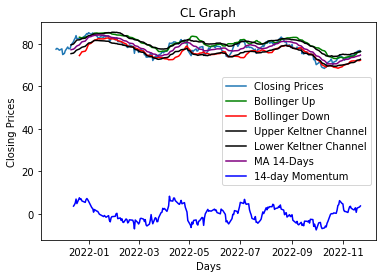

In [10]:
%matplotlib inline

today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'CL'
data = get_data(ticker=ticker, start_date = last_year, end_date = None, index_as_date = True, interval = '1d')
df = gather_data(data)
plt.title(ticker + ' Graph')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['close'], label='Closing Prices')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='green')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='red')
plt.plot(df['upper_KC'], label='Upper Keltner Channel', c='black')
plt.plot(df['lower_KC'], label='Lower Keltner Channel', c='black')
plt.plot(df['MA'], label='MA 14-Days', c='purple')
plt.plot(df['momentum'], label='14-day Momentum', c='blue')
plt.legend()
plt.show()

# ML Predictions PART 1: Data Pre-Processing

In [60]:
# Step 1: Read data
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=5))
ticker = 'DE'
data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
dataset_train = gather_data(data)
# Select features to be involved in training and prediction and target to predict
features = list(dataset_train[['open','upper_KC','lower_KC','bollinger_up','bollinger_down','MA']])#,'high','low','volume','momentum' REMOVED DUE TO NON-LINEARITY
dataset_train['3-day-close']=dataset_train['close'].shift(-3)#shift by 3 days to get the closing price 3 days later
target = list(dataset_train[['3-day-close']])#target = list(dataset_train[['close']])
dataset_train.dropna(inplace=True) # THIS IS THE WORST WAY TO DEAL WITH N/A VALUES. KNN DOES NOT WORK AS FIRST VALUES ARE NaN. DOING MEDIAN
X = dataset_train[features]
y = dataset_train[target]
# Scale data
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features].values)
# Split the data for train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'X_train:\n{X_train}\n\nX_test:\n{X_test}\n\ny_train:\n{y_train}\n\ny_test:\n{y_test}')

(988, 6) (248, 6) (988, 1) (248, 1)
X_train:
                open  upper_KC  lower_KC  bollinger_up  bollinger_down  \
2021-03-30  1.298064  1.261319  1.308716      1.243432        1.366824   
2022-06-08  1.236456  1.342165  1.207085      1.298988        1.152323   
2020-01-17 -0.649879 -0.683662 -0.619566     -0.697438       -0.591043   
2018-11-23 -1.015965 -0.961297 -0.981573     -1.002165       -0.965135   
2021-07-30  1.223829  1.136708  1.226910      1.117519        1.212057   
...              ...       ...       ...           ...             ...   
2020-12-03  0.193086  0.147390  0.176269      0.120609        0.245411   
2022-06-10  0.991346  1.251266  1.222237      1.217834        1.190820   
2020-11-18  0.192577  0.091173  0.062549      0.095442       -0.009284   
2022-08-01  1.011611  0.841753  0.838372      0.848404        0.640023   
2020-03-05 -0.821771 -0.725422 -0.783624     -0.721891       -0.749687   

                  MA  
2021-03-30  1.357298  
2022-06-08  1.162300

C:\Users\slogozzo\AppData\Local\Temp\ipykernel_33412\1548077292.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features].values)


# Check for linearity

In [61]:
for feature in features:
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train[feature], dataset_train['close'])
    print(f'At {feature}, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['volume'], dataset_train['close'])
# print(f'At volume, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['momentum'], dataset_train['close'])
# print(f'At momentum, r_value: {r_value**2}')

At open, r_value: 0.9980100127156811
At upper_KC, r_value: 0.9864205394721535
At lower_KC, r_value: 0.9885161207522438
At bollinger_up, r_value: 0.9811617352944009
At bollinger_down, r_value: 0.9819567982445766
At MA, r_value: 0.9892901952534143


Surprisingly, we see that Volume and Momentum are correlated very little to Closing prices. Only 0.010511741252537113 for volume and 0.02194343991238041 for momentum.
Remember, r_value is between 0 and 1, where 0 is bad and 1 is good

# Now plot everything to double check for linearity at those values

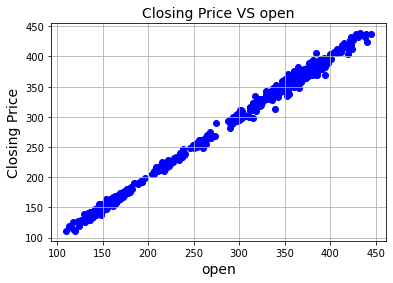

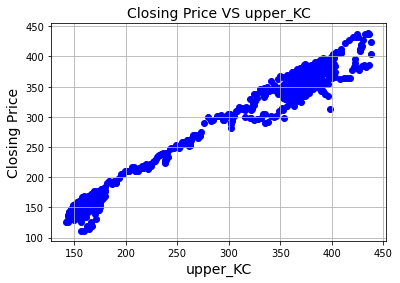

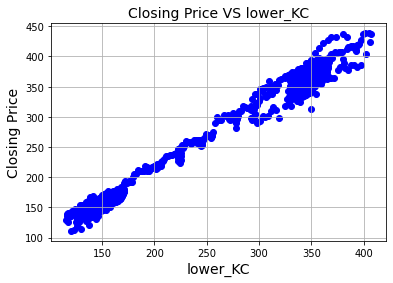

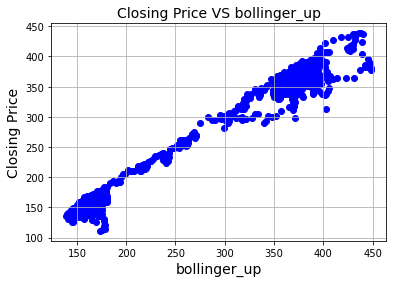

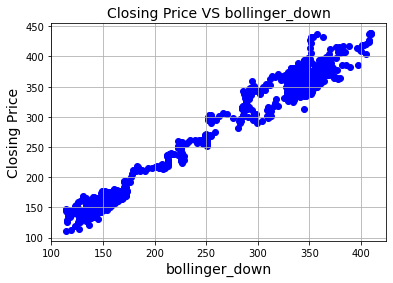

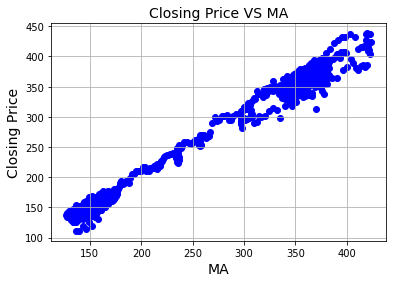

In [62]:
%matplotlib inline

for feature in features:
    plt.scatter(dataset_train[feature], dataset_train['close'], color='blue')
    plt.title(f'Closing Price VS {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Closing Price', fontsize=14)
    plt.grid(True)
    plt.show()

# Perform Multiple Linear Regression

In [63]:
# Train model using train data:
X_train = sm.add_constant(X_train) # adding a constant

RLMmodel = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()
OLSmodel = sm.OLS(y_train, X_train).fit()
print(RLMmodel.summary())
# Make predictions on test data
X_test = sm.add_constant(X_test)
predictions = RLMmodel.predict(X_test)
# for real,prediction in zip(y_test.values,predictions):
#     print(f'\nReal data: {real}. Predicted value: {prediction}')

#from sklearn.metrics import accuracy_score # THIS IS USED FOR CLASSIFIERS
print(f'r2 score: {r2_score(y_test,predictions)}')
# print(f'\nPredictions: {predictions}')
# print(f'\nActual data: {y_test}')


                    Robust linear Model Regression Results                    
Dep. Variable:            3-day-close   No. Observations:                  988
Model:                            RLM   Df Residuals:                      981
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 22 Nov 2022                                         
Time:                        16:23:40                                         
No. Iterations:                    21                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            240.4215      0.272    884.

In [64]:
# Let's try making a prediction
open = 414.00
keltner_up = 415.37
keltner_down = 386.02
bb_up = 414.66
bb_down = 388.51
ma = 401.59
real_data_today = scaler.transform([[open,keltner_up,keltner_down,bb_up,bb_down,ma]])
real_data_today = np.insert(real_data_today[0], 0, 1) # Add constant like in the model to add a y-int
predicted = RLMmodel.predict(real_data_today)
print(f'Price of {ticker} should go to ${predicted[0]} in 3 days')

Price of DE should go to $412.12642165112896 in 3 days
